# JAK2 activity maximization with Deep Reinforcement Learning demo

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with maximized pIC50 for JAK2. We will use a combination of different optimization strategies including fine-tuning (aka transfer learning), policy gradient and policy gradient with experince replay.

## Imports

In [25]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch

In [28]:
use_cuda = torch.cuda.is_available()

In [29]:
import numpy as np

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from stackRNN import StackAugmentedGRU
from predictor import RandomForestQSAR
from data import GeneratorData
from data import PredictorData
from data import sanitize_smiles
from data import cross_validation_split
from data import save_smi_to_file
from reinforcement import Reinforcement
from ReplayMemory import ReplayMemory

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [31]:
threshold = 0.1

## Reading data

In [32]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'
jak2_data_path = './data/jak2_data.csv'

In [33]:
gen_data = GeneratorData(training_data_path=gen_data_path, use_cuda=use_cuda)

In [34]:
jak2_data = PredictorData(path=jak2_data_path, use_cuda=use_cuda, cols=[0, 1])

In [35]:
jak2_data.binarize(threshold=7.0)

(array([ 666.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1245.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

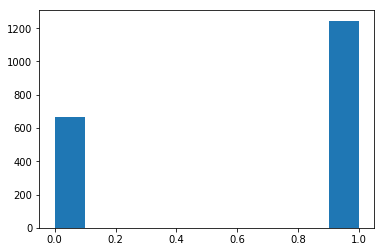

In [36]:
plt.hist(jak2_data.binary_labels)

In [37]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
char2idx = {}
gen_data.load_dictionary(tokens, char2idx)
jak2_data.load_dictionary(tokens, char2idx)

In [38]:
jak2_data.n_characters

45

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [39]:
def plot_hist(prediction, n_to_generate, threshold):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    print("Proportion > threshold:", len(np.where(prediction >= threshold)[0])/len(prediction))
    plt.hist(prediction)
    plt.axvline(x=threshold, color='red')
    plt.xlabel('Predicted pIC50')
    plt.title('Distribution of predicted logP for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Updates data structure for fine-tuning (aka transfer learning)

6) Pushes newly generated SMILES to experience replay pool

6) Returns valid SMILES and their predicted logPs

In [40]:
def estimate_and_update(n_to_generate):
    generated = []
    for _ in range(n_to_generate):
        generated.append(my_generator.evaluate(gen_data)[1:-1])
    
    sanitized = list(np.unique(sanitize_smiles(generated))[1:])
    smiles, prediction, nan_smiles = jak2_predictor.predict(sanitized)
    plot_hist(prediction, n_to_generate, threshold)
    
    for i in np.where(prediction >=threshold)[0]:
        transfer_pool.append('<' + smiles[i] + '>')
    
    save_smi_to_file(transfer_data_path, transfer_pool)
    transfer_data.update_data(transfer_data_path)
    
    for i in range(len(transfer_data.file)):
        replay.push(transfer_data.file[i])
        
    return smiles, prediction

## Initializing models

Initialize stack-augmented generative RNN:

In [41]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
lr = 0.01

my_generator = StackAugmentedGRU(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, stack_width=stack_width,
                                 stack_depth=stack_depth, use_cuda=use_cuda, n_layers=1,
                                 optimizer='Adadelta', lr=lr)

if use_cuda:
    my_generator = my_generator.cuda()

Load pretrained parameters into the model:

In [42]:
my_generator.load_model('./checkpoints/generator/checkpoint_biggest')

Initialize random forest predictive model:

In [43]:
jak2_predictor = RandomForestQSAR(model_type='classifier', n_estimators=100, n_ensemble=5)

Load pretrained parameters into the model:

In [44]:
jak2_predictor.load_model('./checkpoints/JAK2/')

C:\Users\U047856\Programs\anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\U047856\Programs\anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Uncomment cell below to train RF from scratch:

In [45]:
#cross_val_data, cross_val_labels = cross_validation_split(jak2_data.smiles, jak2_data.binary_labels)
#cv_metric, metric_type = jak2_predictor.fit_model(PredictorData, cross_val_data, cross_val_labels)
#jak2_predictor.save_model('./checkpoints/JAK2/')

Initialize reinforcement object for biasing properties and experience replay pool:

In [46]:
RL = Reinforcement(my_generator, jak2_predictor)
replay = ReplayMemory(capacity=10000)

Initialize data object for fine-tuning (aka transfer learning):

In [47]:
transfer_data_path = './data/jak2_transfer_data.smi'
f = open(transfer_data_path, 'w')
f.close()
transfer_pool = []
transfer_data = GeneratorData(transfer_data_path)
transfer_data.load_dictionary(tokens, char2idx)

Estimate unbiased SMILES and update replay pool and transfer data:

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(n_to_generate=20000)

C:\Users\U047856\Programs\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
for i in np.where(prediction_unbiased >=threshold)[0]:
        transfer_pool.append('<' + smiles_unbiased[i] + '>')
    
save_smi_to_file(transfer_data_path, transfer_pool)
transfer_data.update_data(transfer_data_path)

In [ ]:
for i in range(len(jak2_data.smiles)):
    replay.push(jak2_data.smiles[i])
for i in range(len(transfer_data.file)):
    replay.push(transfer_data.file[i])

## Train the model

In [ ]:
rewards = []
n_to_generate = 1000
n_policy_replay = 10
n_policy = 5
n_transfer = 500
n_iterations = 5
prediction_log = []

for _ in range(n_iterations):
     
    ### Transfer learning 
    RL.transfer_learning(transfer_data, n_epochs=n_transfer)
    _, prediction = estimate_and_update(n_to_generate)
    prediction_log.append(prediction)
    if len(np.where(prediction >= threshold)[0])/len(prediction) > 0.15:
        threshold = min(threshold + 0.05, 0.8)

    ### Policy gtadient with experience replay 
    for _ in range(n_policy_replay):
        rewards.append(RL.policy_gradient_replay(gen_data, replay, threshold=threshold, n_batch=10))
        print(rewards[-1])
    
    _, prediction = estimate_and_update(n_to_generate)
    prediction_log.append(prediction)
    if len(np.where(prediction >= threshold)[0])/len(prediction) > 0.15:
        threshold = min(threshold + 0.05, 0.8)
    
    ### Policy graient without experinece replay 
    for _ in range(n_policy):
        rewards.append(RL.policy_gradient(gen_data, threshold=threshold, n_batch=10))
        print(rewards[-1]) 

    _, prediction = estimate_and_update(n_to_generate)
    prediction_log.append(prediction)
    if len(np.where(prediction >= threshold)[0])/len(prediction) > 0.15:
        threshold = min(threshold + 0.05, 0.8)

In [ ]:
smiles_biased, prediction_biased = estimate_and_update(n_to_generate=10000)

In [ ]:
plt.hist(prediction_biased)

## Estimating similarity of biased and training datasets

In [ ]:
generated_mols = [Chem.MolFromSmiles(sm) for sm in smiles_biased]
generated_fps = [FingerprintMols.FingerprintMol(x) for x in generated_mols]

In [ ]:
jak2_mols = [Chem.MolFromSmiles(sm) for sm in jak2_data.smiles]
jak2_fps = [FingerprintMols.FingerprintMol(x) for x in jak2_mols]

In [ ]:
#sim = []
#sim_smiles = []
#sim_labels = []
for fp1 in generated_fps[2521:]:
    max_sim = 0.0
    for j in range(len(jak2_fps)):
        fp2 = jak2_fps[j]
        tmp = DataStructs.FingerprintSimilarity(fp1,fp2)
        if tmp > max_sim:
            max_sim = tmp
            tmp_sm = jak2_data.smiles[j]
            tmp_label = jak2_data.property[j]
    sim.append(max_sim)
    sim_smiles.append(tmp_sm)
    sim_labels.append(tmp_label)

In [ ]:
plt.hist(sim)
print(len(sim))

In [ ]:
for i in range(len(smiles_biased)):
    if prediction_biased[i] == 1.0:
        print(smiles_biased[i])

In [ ]:
save_smi_to_file('jak2_maximized.smi', smiles_biased)

In [ ]:
torch.save(my_generator.state_dict(), './checkpoints/generator/jak2_max')

In [ ]:
for i in range(100):
    jak2_compounds = []
    while (len(jak2_compounds) <= 1000):
        sm = my_generator.evaluate(gen_data, temperature=0.6)[1:-1]
        clean_sm, pred, nan_sm = jak2_predictor.predict([sm])
        if len(clean_sm) > 0 and pred[0] >= 0.8:
            jak2_compounds += clean_sm
    save_smi_to_file('./generated_compounds/jak2_v1/' + str(i) + '.txt', jak2_compounds)
    print(str(i*1000) + ' SMILES generated')

In [ ]:
jak2_compounds